In [1]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

### Датасет: Yeast cell in microstructures

In [2]:
# ! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
# ! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

Посмотрим на структуру данных:

In [3]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
train_dir = dataset_dir / "train"
fname = "0.pt"

for subdir in train_dir.glob("*"):
    print(f"{subdir.stem} shape: ", torch.load(subdir / fname).shape)

bounding_boxes shape:  torch.Size([3, 4])
classes shape:  torch.Size([3])
instances shape:  torch.Size([3, 256, 256])
inputs shape:  torch.Size([256, 256])


Визуализируем один пример:

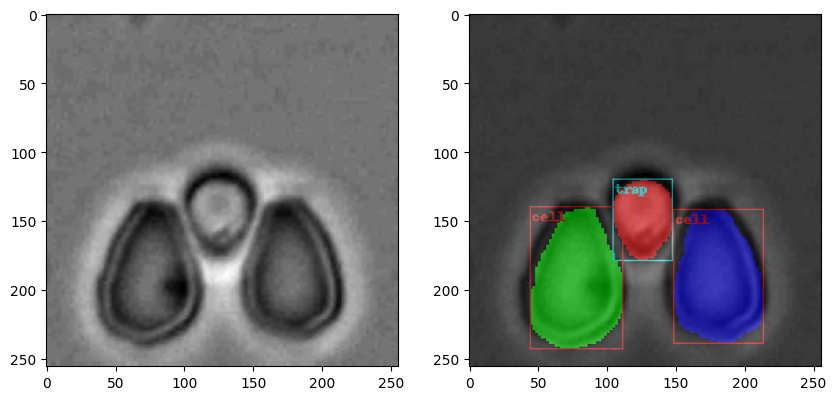

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(torch.load(train_dir / "inputs" / fname), cmap="gray")
ax[1].imshow(torch.load(train_dir / "inputs" / fname), cmap="gray")


colordict = {0: "red", 1: "cyan"}
class_names = {0: "cell", 1: "trap"}

classes = torch.load(train_dir / "classes" / fname)

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(
        torch.load(train_dir / "instances" / fname)
    ),
    boxes=torch.load(train_dir / "bounding_boxes" / fname),
    colors=[colordict[i] for i in classes.tolist()],
    labels=[class_names[i] for i in classes.tolist()],
)

ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.5)

### Напишем датамодуль

Сначала реализуем более общий случай: датасет для instance segmentation. Из него легко будет получить датасет для semantic segmentation

In [5]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        ...

    def __len__(self) -> int:
        ...

Проверим, что всё отрисовывается корректно:

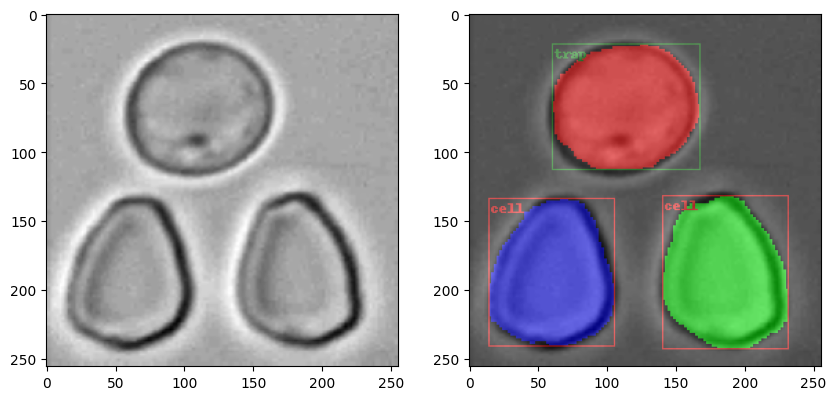

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

train_dataset = YeastDataset(train_dir)

x, target = train_dataset[0]
ax[0].imshow(x[0], cmap="gray")
ax[1].imshow(x[0], cmap="gray")


colordict = {1: "red", 2: "green"}
class_names = {1: "cell", 2: "trap"}

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(target["masks"]),
    boxes=target["boxes"],
    colors=[colordict[i.item()] for i in target["labels"]],
    labels=[class_names[i.item()] for i in target["labels"]],
)
ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.5)

А теперь отнаследуемся и сделаем правки, чтобы возвращались маски по классам:

In [7]:
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        semantic_mask = torch.zeros_like(image[0], dtype=torch.long)
        ...

        return image, semantic_mask

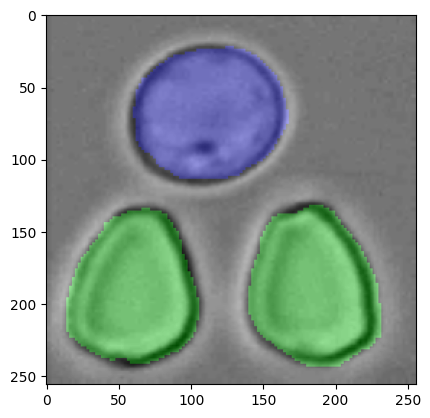

In [8]:
train_dataset = YeastSemanticSegmDataset(train_dir)

x, y = train_dataset[0]
y = torch.nn.functional.one_hot(y, 3).permute(2, 0, 1).float()
y[0] = 0.0

fig, ax = plt.subplots(1, 1)
ax.imshow(x[0], cmap="gray")
ax.imshow(transforms.ToPILImage()(y), alpha=0.3)

#### Датамодуль: универсальный для обеих задач

In [9]:
from typing import Any, Callable, Type

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [10]:
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=2,
)
datamodule.setup("fit")
images, masks = next(iter(datamodule.train_dataloader()))
print(images.shape)
print(masks.shape)

torch.Size([2, 1, 256, 256])
torch.Size([2, 256, 256])


### Модель для семантической сегментации

Возьмём реализацию Unet из https://github.com/milesial/Pytorch-UNet

<!-- [](https://camo.githubusercontent.com/41ded1456b9dbe13b8d73d8da539dac95cb8aa721ebe5fb798af732ca9f04c92/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67?raw=true) -->

<!-- [network architecture](https://i.imgur.com/jeDVpqF.png) -->

<img src="https://i.imgur.com/jeDVpqF.png" style="background:white" width="600"/>

Блоки из оригинального репозитория:

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

Модель изначально реализована так:

In [21]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

В такой реализации нет возможности создавать сеть произвольного размера. Давайте перепишем в таком виде:

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        ...

    def forward(self, x: Tensor) -> Tensor:
        ...

In [12]:
model = UNet(n_channels=1, n_channels=3, channel_sizes=(16, 32, 64, 128))
sum([p.numel() for p in model.parameters()])

482483

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Проверим, что модель способна выучить один батч данных:

In [19]:
n_steps = 50
for i in range(n_steps):
    predictions = ...
    loss = ...

tensor(0.0584, grad_fn=<NllLoss2DBackward0>)
tensor(0.0536, grad_fn=<NllLoss2DBackward0>)
tensor(0.0462, grad_fn=<NllLoss2DBackward0>)
tensor(0.0494, grad_fn=<NllLoss2DBackward0>)
tensor(0.0331, grad_fn=<NllLoss2DBackward0>)
tensor(0.0228, grad_fn=<NllLoss2DBackward0>)
tensor(0.0182, grad_fn=<NllLoss2DBackward0>)
tensor(0.0156, grad_fn=<NllLoss2DBackward0>)
tensor(0.0137, grad_fn=<NllLoss2DBackward0>)
tensor(0.0120, grad_fn=<NllLoss2DBackward0>)


Визуализаруем предсказания:

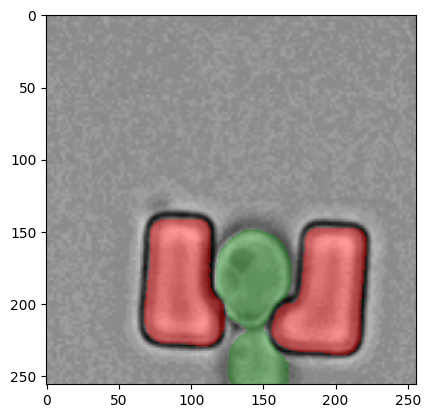

In [20]:
_pred_mask = torchvision.utils.draw_segmentation_masks(
    transforms.Compose(
        [
            transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
            transforms.ConvertImageDtype(torch.uint8),
            transforms.Lambda(lambda x: x.repeat((3, 1, 1))),
        ]
    )(images[0]),
    masks=torch.nn.functional.one_hot(predictions["out"].argmax(dim=1), 3)[0].permute(
        2, 0, 1
    )[1:]
    > 0,
    alpha=0.4,
    colors=["red", "green"],
)

plt.imshow(transforms.ToPILImage()(_pred_mask))

### Упражнения

1. Напишите `LightningModule` для обучения модели, проведите эксперименты. Какой точности сегментации удалось добиться?
2. Попробуйте обучить какую-нибудь архитектуру из torchvision, например `torchvision.models.segmentation.DeepLabV3`. Как она обучается при сопоставимом количестве параметров с нашей UNet?
3. Усложним задачу: теперь нужно сделать instance segmentation. Модуль данных уже есть выше, осталось определиться с моделью. Загляните в `torchvision.models.detection.MaskRCNN`, попробуйте разобраться, в чём будет отличие от задачи детекции. Напишите простой цикл обучения и обучитесь на одном батче
4. Напишите `LightningModule` для обучения MaskRCNN, проведите эксперименты